# Volumetric Surface Reconstruction

Explain process and approach

### Dependencies

In [1]:
%matplotlib notebook

import numpy as np
import maxflow
import matplotlib.pyplot as plt
from skimage import measure
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from mpl_toolkits.mplot3d import Axes3D

## Load Data

Describe the data and what it is 

In [2]:
class Data:
    def __init__(self, data_set):
        self.data_set = data_set
        self.init_bounding_box()
        self.load_camera_info()
        
    def init_bounding_box(self):
        bounding_boxes = {
            'dinoSR': {
                'x': np.array([-0.07, 0.02]),
                'y': np.array([-0.02, 0.07]),
                'z': np.array([-0.07, 0.02])
            },
            'dinoR': {
                'x': np.array([-0.03, 0.06]),
                'y': np.array([-0.022, 0.11]),
                'z': np.array([-0.02, 0.06])
            },
            'templeSR': {
                'x': np.array([-0.08, 0.03]),
                'y': np.array([0.0, 0.18]),
                'z': np.array([-0.02, 0.06])
            }
        }
        self.bounding_box = bounding_boxes[self.data_set]
        
    def load_camera_info(self):
        
        # Dictionary of data_sets with image_paths
        image_paths = {
            'dinoSR': 'dinoSparseRing/',
            'dinoR': 'dinoRing/',
            'templeSR': 'templeSparseRing/'
        }
        
        # Open file in read mode
        path = image_paths[self.data_set]
        fp = open(path+self.data_set+'_par.txt', 'r')  

        num_images = int(fp.readline())
        
        P = []           # projection matrices
        T = []           # camera positions
        imgs = []        # images
        
        for i in xrange(num_images):
            raw_info = fp.readline().split()
            img_name = raw_info[0]
            raw_info = map(float, raw_info[1:])

            # Projection Matrix of the camera
            K = np.array(raw_info[0:9]).reshape(3,3)
            R = np.array(raw_info[9:18]).reshape(3,3)
            t = np.array(raw_info[18:])
            Rt = np.stack((R[:,0], R[:,1], R[:,2], t), axis=1)
            P.append(np.matmul(K, Rt))
            
            # Position of camera is Translation vector
            T.append(t)

            # Read Image and store
            img = plt.imread(path+img_name)
            imgs.append(img)
        
        self.P = np.array(P)
        self.T = np.array(T)
        self.imgs = np.array(imgs)
            
    def init_silhouttes(self, Segment):
        sils = []        # silhouettes
        
        for img in self.imgs:
            # create silhouttes using segmentation method
            sil = Segment(img).run()
            sils.append(sil)
        
        self.sils = np.array(sils)
    

### Display Data

Image shape:  (480, 640, 3)


<IPython.core.display.Javascript object>


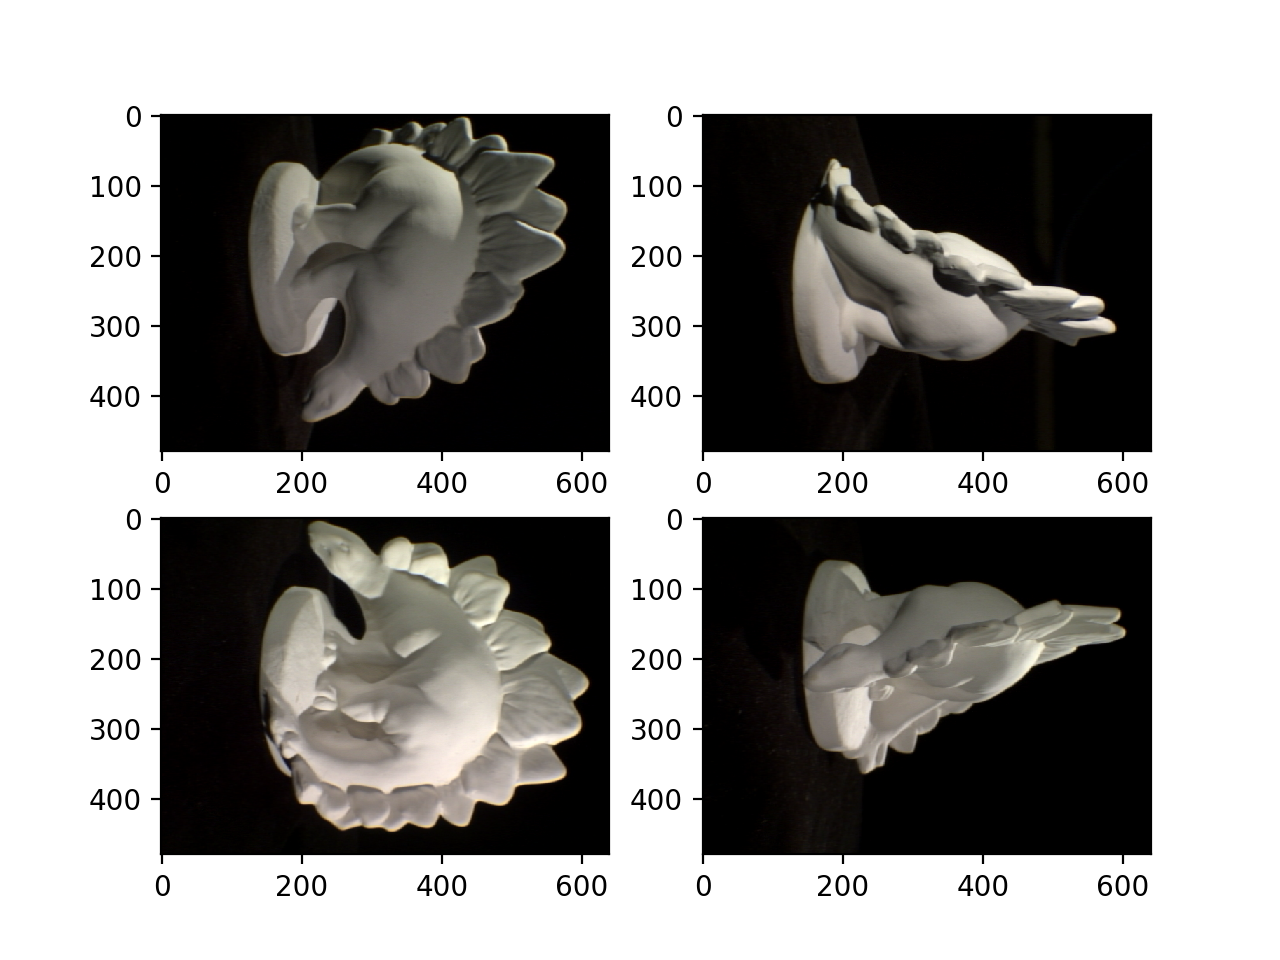

In [3]:
data = Data('dinoSR')

print "Image shape: ", data.imgs[0].shape

num_images = data.imgs.shape[0]
plt.figure()
plt.subplot(2,2,1)
plt.imshow(data.imgs[0*num_images/4])
plt.show()
plt.subplot(2,2,2)
plt.imshow(data.imgs[1*num_images/4])
plt.show()
plt.subplot(2,2,3)
plt.imshow(data.imgs[2*num_images/4])
plt.show()
plt.subplot(2,2,4)
plt.imshow(data.imgs[3*num_images/4])
plt.show()
    

## Segmentation

Explain what is done to segment the images. Explain what can be done

### Threshold Segmentation

In [4]:
class ThresholdSegment:
    def __init__(self, image, threshold=0.1):
        self.image = image
        self.threshold = threshold
    
    def run(self):
        sil = np.zeros((self.image.shape[0], self.image.shape[1]))
        sil[np.where(self.image > self.threshold)[:2]] = 1
        return sil


### Display Results

<IPython.core.display.Javascript object>


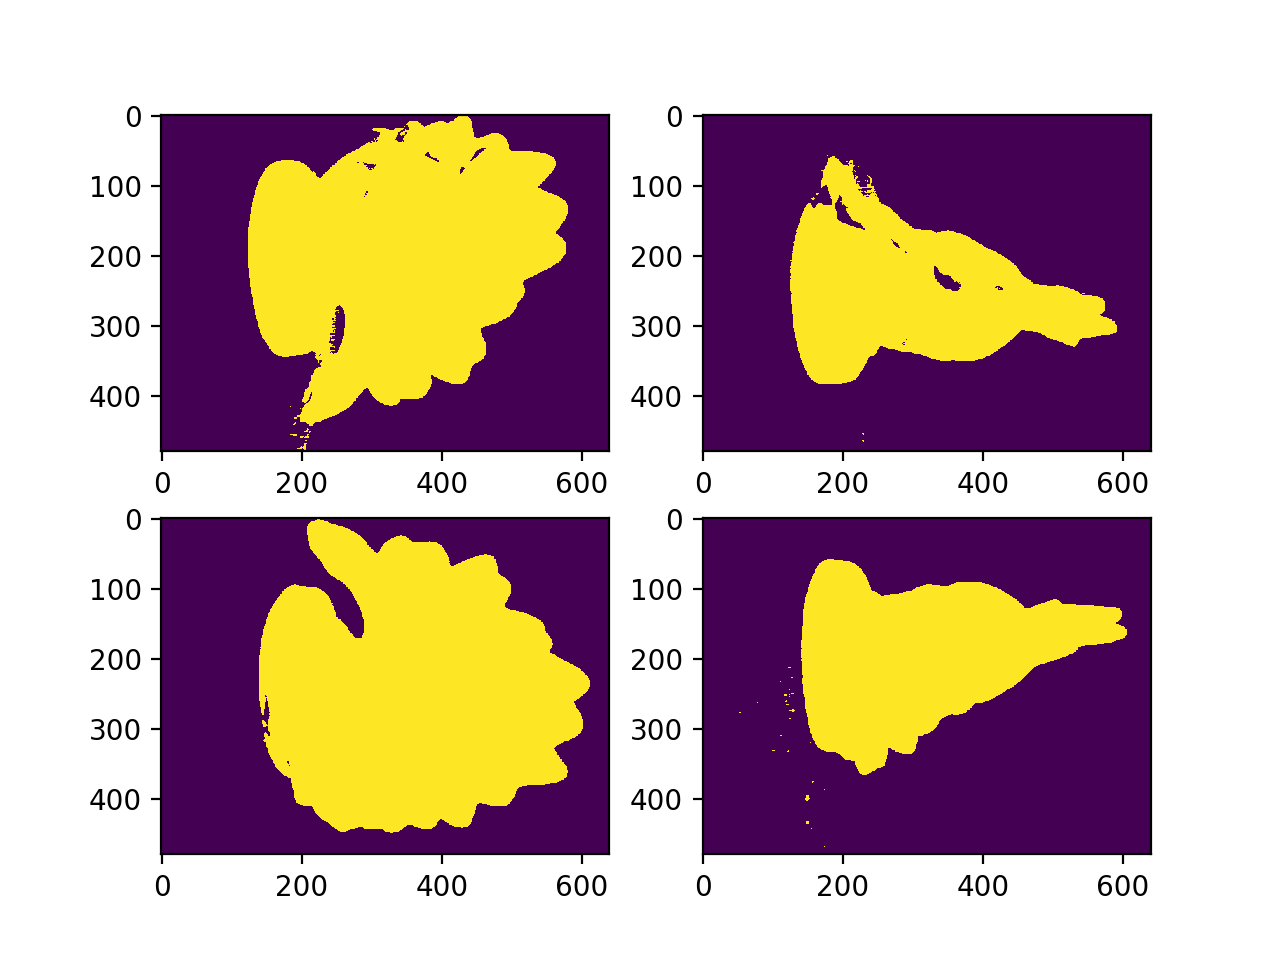

In [5]:
data.init_silhouttes(ThresholdSegment)

plt.figure()
plt.subplot(2,2,1)
plt.imshow(data.sils[0*num_images/4])
plt.show()
plt.subplot(2,2,2)
plt.imshow(data.sils[1*num_images/4])
plt.show()
plt.subplot(2,2,3)
plt.imshow(data.sils[2*num_images/4])
plt.show()
plt.subplot(2,2,4)
plt.imshow(data.sils[3*num_images/4])
plt.show()

### K-means Segmentation
### Graph-Cut Segmentation

## Visual Hull

Explain what Visual hull is and process behind the approach

In [6]:
class Voxel:
    def __init__(self, args):
        self.x = args[0]
        self.y = args[1]
        self.z = args[2]
        self.val = args[3]
    
    def log(self):
        print "\tx: ", self.x
        print "\ty: ", self.y
        print "\tz: ", self.z
        print "\tval: ", self.val
    
    def homo(self):
        return np.array([self.x, self.y, self.z, 1]).reshape(4, 1)

class VisualHull:
    def __init__(self, 
                 data, 
                 voxel_size=np.array([0.002, 0.002, 0.002])):
        
        self.data = data
        self.voxel_size = voxel_size

        self.sils = self.data.sils
        self.P = self.data.P
        self.T = self.data.T
        
        self.img_height = self.data.imgs.shape[1]
        self.img_width = self.data.imgs.shape[2]
        
    def initialize_voxels(self, xlim, ylim, zlim):
        
        # Determine shape of visual hull grid
        hull_shape = np.zeros(3)
        hull_shape[0] = abs(xlim[1] - xlim[0])/self.voxel_size[0]
        hull_shape[1] = abs(ylim[1] - ylim[0])/self.voxel_size[1]
        hull_shape[2] = abs(zlim[1] - zlim[0])/self.voxel_size[2]
        self.hull_shape = hull_shape + np.ones(3)
        
        # Compute total voxels using grid shape
        self.total_voxels = np.prod(self.hull_shape)

        # List storing (x, y, z, val) of each voxel
        self.voxels2D_list = np.ones((int(self.total_voxels), 4), float)
        
        # Compute increment and decrement step direction
        sx = xlim[0]
        ex = xlim[1]
        sy = ylim[0]
        ey = ylim[1]
        sz = zlim[0]
        ez = zlim[1]

        if ex > sx:
            x_step = self.voxel_size[0]
        else:
            x_step = -self.voxel_size[0]

        if ey > sy:
            y_step = self.voxel_size[1]
        else:
            y_step = -self.voxel_size[1]

        if ez > sz:
            z_step = self.voxel_size[2]
        else:
            z_step = -self.voxel_size[2]
            
        self.x_step = x_step
        self.y_step = y_step
        self.z_step = z_step
        
        x_linspace = np.linspace(sx, ex, int(self.hull_shape[0]))
        y_linspace = np.linspace(sy, ey, int(self.hull_shape[1]))
        z_linspace = np.linspace(sz, ez, int(self.hull_shape[2]))
        
        # Initialize voxel list
        l = 0;
        for z in z_linspace:
            for x in x_linspace:
                for y in y_linspace:
                    self.voxels2D_list[l, 0:3] = np.array([x, y, z])
                    l = l+1
                    
    def create_visual_hull(self):
        
        # Homogeneous 3D world coordinates 
        object_points3D_homo = np.transpose(self.voxels2D_list)
        
        # Iterate through each camera position 
        print "Processing frames: ",
        for i in xrange(self.P.shape[0]):
            print i+1, " ",
            
            # Homogeneous image coordinate for camera/image i
            points2D_homo = np.matmul(self.P[i], object_points3D_homo)
            
            # Remove infinity points
            inf_ind = np.where(points2D_homo[2] == 0)
            points2D_homo[:, inf_ind] = 1
            
            # Image coordinates
            points2D = np.divide(points2D_homo[0:2], [points2D_homo[2], points2D_homo[2]]);

            # Remove points outside image boundary
            ind_x_lt_0 = np.where(points2D[0] < 0)
            ind_y_lt_0 = np.where(points2D[1] < 0)
            ind_x_gt_w = np.where(points2D[0] >= self.img_width)
            ind_y_gt_h = np.where(points2D[1] >= self.img_height)
            points2D[:, ind_x_lt_0] = 1
            points2D[:, ind_y_lt_0] = 1
            points2D[:, ind_x_gt_w] = 1
            points2D[:, ind_y_gt_h] = 1
            
            # Make voxel value 0 for those not being projected
            ind = np.ravel_multi_index(
                (points2D[1,:].astype(int), points2D[0,:].astype(int)), 
                dims=(self.img_height, self.img_width), order='C')
            cur_silhouette = self.data.sils[i]
            img_val = cur_silhouette.ravel()[ind]
            zero_ind = np.where(img_val == 0)[0]
            
            # Update list of voxels
            self.voxels2D_list[zero_ind, 3] = 0
            
    def create_grids(self):
        # Initialize Grids - one with all voxel info, one just with voxel values
        self.voxel3D = np.zeros([int(self.hull_shape[1]), int(self.hull_shape[0]), int(self.hull_shape[2])], dtype=object)
        self.voxel3D_val = np.zeros([int(self.hull_shape[1]), int(self.hull_shape[0]), int(self.hull_shape[2])], dtype=float)

        # Assign values in 3D grid
        l=0
        for zi in xrange(self.voxel3D.shape[2]):
            for xi in xrange(self.voxel3D.shape[1]):
                for yi in xrange(self.voxel3D.shape[0]):
                    self.voxel3D[yi, xi, zi] =  Voxel(self.voxels2D_list[l,:])
                    self.voxel3D_val[yi, xi, zi] = self.voxels2D_list[l, 3]
                    l = l+1
                    
    def plot_marching_cube(self):
        # Display resulting triangular mesh using Matplotlib.
        verts, faces, normals, values = measure.marching_cubes_lewiner(self.voxel3D_val.T, 0)

        fig = plt.figure()
        ax = fig.gca(projection='3d')

        # Fancy indexing: `verts[faces]` to generate a collection of triangles
        mesh = Poly3DCollection(verts[faces])
        mesh.set_edgecolor('k')
        ax.add_collection3d(mesh)

        ax.set_xlabel("x-axis")
        ax.set_ylabel("y-axis")
        ax.set_zlabel("z-axis")

        ax.set_xlim(0, self.voxel3D_val.T.shape[0]) # a = 6 (times two for 2nd ellipsoid)
        ax.set_ylim(0, self.voxel3D_val.T.shape[1]) # b = 10
        ax.set_zlim(0, self.voxel3D_val.T.shape[2]) # c = 16

        plt.tight_layout()
        plt.show()

    def run(self):
        self.initialize_voxels(
            self.data.bounding_box['x'], 
            self.data.bounding_box['y'], 
            self.data.bounding_box['z'])
        self.create_visual_hull()
        self.create_grids()
        self.plot_marching_cube()


### Results

Processing frames:  1   2   3   4   5   6   7   8   9   10   11   12   13   14   15   16  

<IPython.core.display.Javascript object>


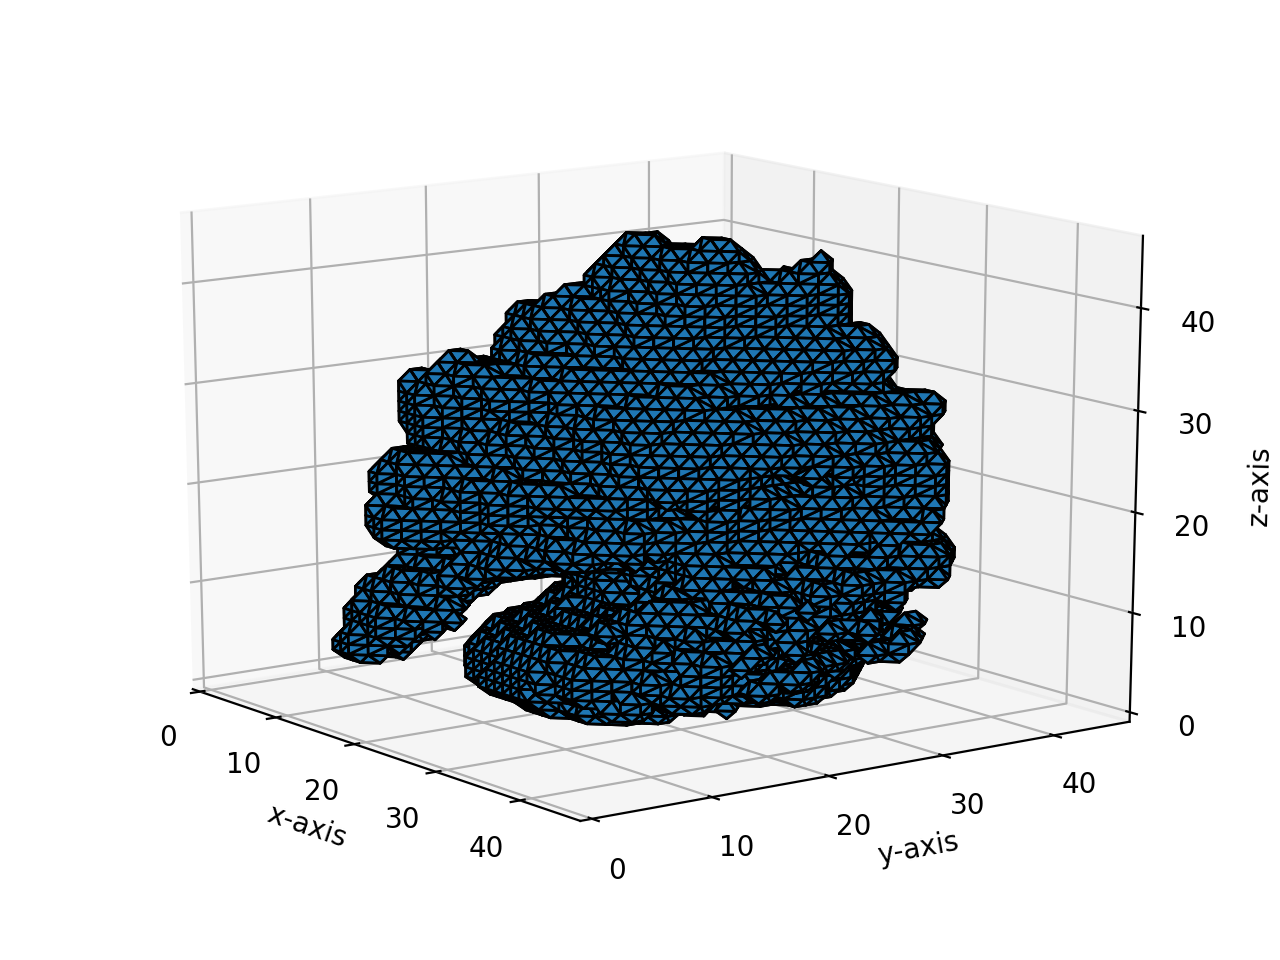

In [7]:
VisualHull(data).run()

# Volumetric Graph Cuts via Photoconsistency